In [1]:
%matplotlib inline
from matplotlib import style
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# Creating Engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

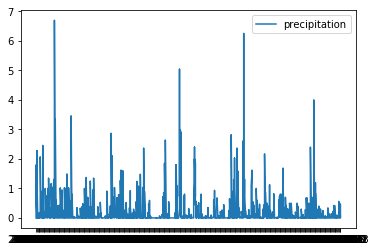

In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= '2016-08-23').\
    order_by(Measurement.date).all()

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

precip = pd.DataFrame(precip, columns=['date', 'prcp'])
precip = precip.set_index('date')
precip = precip.fillna(0)

# Sort the dataframe by date

precip = precip.sort_index(ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data

plt.plot(precip.index, precip['prcp'], label='precipitation')
plt.legend()
plt.show()



In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip.describe()

,prcp
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
number_of_stations = Base.classes.station
stations = session.query(number_of_stations).group_by(number_of_stations.name).count()
print(stations)

9


In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
for row in session.query(Measurement.station, func.count(Measurement.id)).\
group_by(Measurement.station).order_by(func.count(Measurement.id).desc()):
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
for row in session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station == "USC00519281"):
    print(row)

(54.0, 85.0, 71.66378066378067)


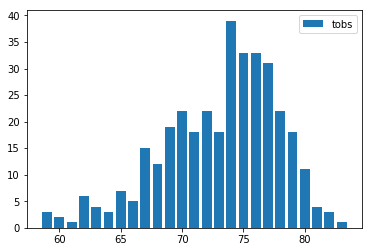

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp = session.query(Measurement.tobs, func.count(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281").\
    filter(Measurement.date >= '2016-08-23').\
    group_by(Measurement.tobs).\
    order_by(Measurement.tobs).all()
    
temp_df = pd.DataFrame(temp, columns=['tobs', 'fred'])

temp_df = temp_df.set_index('tobs')

plt.bar(temp_df.index, temp_df['fred'], label='tobs')
plt.legend()
plt.show()

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2016-08-23', '2017-08-23'))

[(58.0, 74.59058295964125, 87.0)]


<ErrorbarContainer object of 3 artists>

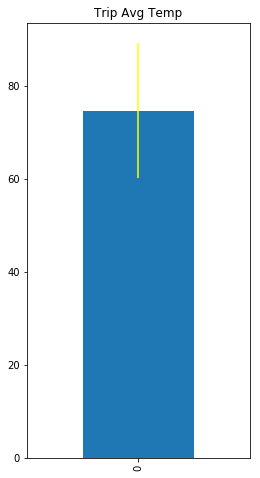

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
avtemp = calc_temps('2016-08-23', '2017-08-23')
avtemp_df = pd.DataFrame(avtemp, columns=['min', 'avg','max'])
avtemp1 = (avtemp_df['max'][0] - avtemp_df['min'][0])/2
ax = avtemp_df['avg'].plot(kind='bar', figsize=(4,8), title="Trip Avg Temp")
ax.errorbar(0, avtemp_df['avg'], avtemp1, solid_capstyle='projecting', ecolor='yellow')

In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query(Station.name, Station.latitude, Station.longitude, Station.elevation,
           func.sum(Measurement.prcp), Measurement.tobs).filter(Station.station == Measurement.station).\
           filter(Measurement.date >= '2016-08-23').\
           group_by(Station.station).all()
rainfall


[('KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 48.510000000000026, 76.0),
 ('KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  33.239999999999995,
  80.0),
 ('MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  147.81000000000006,
  74.0),
 ('PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 4.59, 80.0),
 ('WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  70.03000000000003,
  77.0),
 ('WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 16.089999999999986, 81.0),
 ('WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  38.01,
  80.0)]

In [32]:
from flask import Flask, jsonify


app = Flask(__name__)


@app.route("/")
def home():
    return "These are your routes:"
        /api/v1.0/precipitation
    


@app.route("/normal")
def normal():
    return hello_dict


@app.route("/jsonified")
def jsonified():
    return jsonify(hello_dict)


if __name__ == "__main__":
    app.run(debug=True)

IndentationError: unexpected indent (<ipython-input-32-88d00800285b>, line 10)

Extra Credit

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]